In [1]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [2]:
seed = 42


def seed_everything(seed=42):
    random.seed(seed)  # Python 기본 랜덤 시드 고정
    torch.manual_seed(seed)  # PyTorch CPU 시드 고정
    torch.cuda.manual_seed(seed)  # PyTorch GPU 시드 고정

    torch.backends.cudnn.deterministic = True  # 연산의 결정적(Deterministic) 실행 보장
    torch.backends.cudnn.benchmark = False  # 모델 구조가 고정되지 않으면 비활성화

seed_everything(seed)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

In [4]:
test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)

In [5]:
print(len(test_dataset))

10000


In [6]:
image, label = test_dataset[0]

print(type(image))
print(image.shape)

print(type(label))
print(label)

<class 'torch.Tensor'>
torch.Size([784])
<class 'int'>
7


In [7]:
pil_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.view(-1, 28, 28)),
    transforms.ToPILImage(),
])

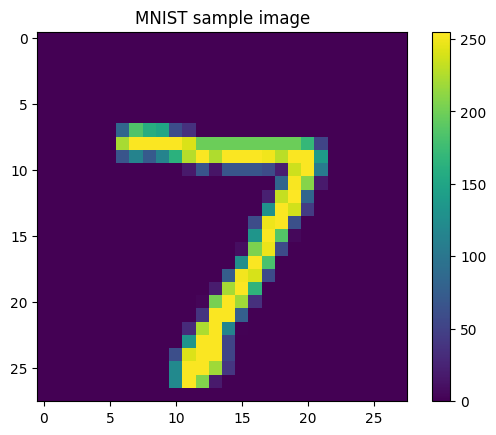

PIL.Image
min: 0, max: 255
Torch.tensor
min: 0.0, max: 1.0


In [8]:
plt.title("MNIST sample image")
cax = plt.imshow(pil_transform(image))
plt.colorbar(cax)
plt.show()

min_val, max_val = pil_transform(image).getextrema()
print(f"PIL.Image")
print(f"min: {min_val}, max: {max_val}")

print(f"Torch.tensor")
print(f"min: {torch.min(image)}, max: {torch.max(image)}")

In [9]:
batch_size = 256
num_workers = 8

test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers)

In [10]:
print(len(test_dataloader))

40


In [11]:
class LinearModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super().__init__()

        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.layers = self.get_layer()

    def get_layer(self):
        layers = nn.ModuleList()

        if self.hidden_sizes:
            layers.append(nn.Linear(self.input_size, self.hidden_sizes[0]))
            layers.append(nn.ReLU())
            if len(self.hidden_sizes) >= 2:
                for idx in range(1, len(self.hidden_sizes)):
                    layers.append(nn.Linear(self.hidden_sizes[idx-1], self.hidden_sizes[idx]))
                    layers.append(nn.ReLU())
            layers.append(nn.Linear(self.hidden_sizes[-1], self.num_classes))
        else:
            layers.append(nn.Linear(self.input_size, self.num_classes))

        return layers
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [12]:
model = LinearModel(784, [500, 300, 100], 10)

In [13]:
print(model.layers)

ModuleList(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)


In [14]:
model.load_state_dict(torch.load("best_model.pth"))

/tmp/ipykernel_91761/1833195287.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

LinearModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [16]:
predict_score = 0
num_samples = 0
for (x, y) in test_dataloader:
    num_samples += y.size(0)
    x = x.to(device)

    output = model(x)
    output_idx = output.argmax(dim=1).cpu()

    sum = (output_idx == y).sum().item()
    predict_score += sum

accuracy = predict_score / num_samples
print(f"accuracy: {accuracy:.4f}")

accuracy: 0.9681


# With Rotation

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.Lambda(lambda x: x.view(-1)),
])

In [18]:
test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)

In [19]:
print(len(test_dataset))

10000


In [20]:
image, label = test_dataset[0]

print(type(image))
print(image.shape)

print(type(label))
print(label)

<class 'torch.Tensor'>
torch.Size([784])
<class 'int'>
7


In [21]:
pil_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.view(-1, 28, 28)),
    transforms.ToPILImage(),
])

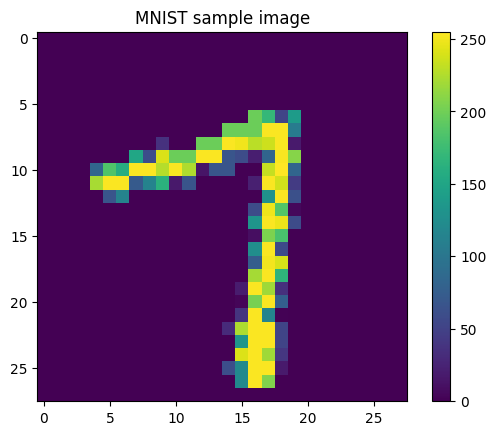

PIL.Image
min: 0, max: 255
Torch.tensor
min: 0.0, max: 1.0


In [22]:
plt.title("MNIST sample image")
cax = plt.imshow(pil_transform(image))
plt.colorbar(cax)
plt.show()

min_val, max_val = pil_transform(image).getextrema()
print(f"PIL.Image")
print(f"min: {min_val}, max: {max_val}")

print(f"Torch.tensor")
print(f"min: {torch.min(image)}, max: {torch.max(image)}")

In [23]:
batch_size = 256
num_workers = 8

test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers)

In [24]:
predict_score = 0
num_samples = 0
for (x, y) in test_dataloader:
    num_samples += y.size(0)
    x = x.to(device)

    output = model(x)
    output_idx = output.argmax(dim=1).cpu()

    sum = (output_idx == y).sum().item()
    predict_score += sum

accuracy = predict_score / num_samples
print(f"accuracy: {accuracy:.4f}")

accuracy: 0.3305


# New

In [25]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [26]:
seed = 42


def seed_everything(seed=42):
    random.seed(seed)  # Python 기본 랜덤 시드 고정
    torch.manual_seed(seed)  # PyTorch CPU 시드 고정
    torch.cuda.manual_seed(seed)  # PyTorch GPU 시드 고정

    torch.backends.cudnn.deterministic = True  # 연산의 결정적(Deterministic) 실행 보장
    torch.backends.cudnn.benchmark = False  # 모델 구조가 고정되지 않으면 비활성화

seed_everything(seed)

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

transform_with_rotation = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.Lambda(lambda x: x.view(-1)),
])

In [28]:
test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)
test_dataset_with_rotation = MNIST(root="./data", train=False, transform=transform_with_rotation, download=True)

In [29]:
print(len(test_dataset))
print(len(test_dataset_with_rotation))

10000
10000


In [30]:
pil_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.view(-1, 28, 28)),
    transforms.ToPILImage(),
])

In [31]:
image, label = test_dataset[0]

print(type(image))
print(image.shape)

print(type(label))
print(label)

<class 'torch.Tensor'>
torch.Size([784])
<class 'int'>
7


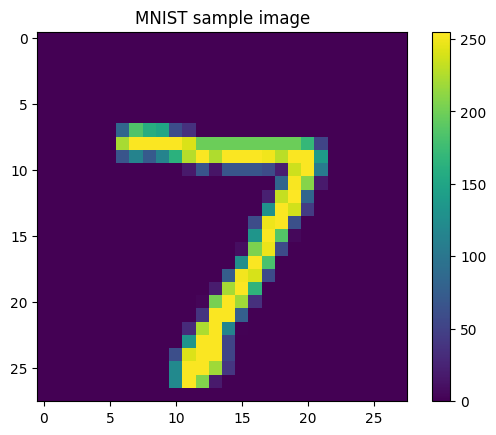

PIL.Image
min: 0, max: 255
Torch.tensor
min: 0.0, max: 1.0


In [32]:
plt.title("MNIST sample image")
cax = plt.imshow(pil_transform(image))
plt.colorbar(cax)
plt.show()

min_val, max_val = pil_transform(image).getextrema()
print(f"PIL.Image")
print(f"min: {min_val}, max: {max_val}")

print(f"Torch.tensor")
print(f"min: {torch.min(image)}, max: {torch.max(image)}")

In [33]:
image, label = test_dataset_with_rotation[0]

print(f"with Rotation")
print(type(image))
print(image.shape)

print(type(label))
print(label)

with Rotation
<class 'torch.Tensor'>
torch.Size([784])
<class 'int'>
7


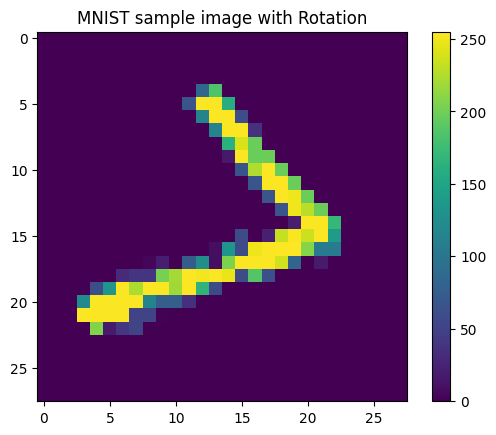

PIL.Image
min: 0, max: 255
Torch.tensor
min: 0.0, max: 1.0


In [34]:
plt.title("MNIST sample image with Rotation")
cax = plt.imshow(pil_transform(image))
plt.colorbar(cax)
plt.show()

min_val, max_val = pil_transform(image).getextrema()
print(f"PIL.Image")
print(f"min: {min_val}, max: {max_val}")

print(f"Torch.tensor")
print(f"min: {torch.min(image)}, max: {torch.max(image)}")

In [35]:
batch_size = 256
num_workers = 8

test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers)
test_dataloader_with_rotation = DataLoader(test_dataset_with_rotation, batch_size, shuffle=False, num_workers=num_workers)

In [36]:
print(len(test_dataloader))
print(len(test_dataloader_with_rotation))

40
40


In [37]:
class LinearModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super().__init__()

        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.layers = self.get_layer()

    def get_layer(self):
        layers = nn.ModuleList()

        if self.hidden_sizes:
            layers.append(nn.Linear(self.input_size, self.hidden_sizes[0]))
            layers.append(nn.ReLU())
            if len(self.hidden_sizes) >= 2:
                for idx in range(1, len(self.hidden_sizes)):
                    layers.append(nn.Linear(self.hidden_sizes[idx-1], self.hidden_sizes[idx]))
                    layers.append(nn.ReLU())
            layers.append(nn.Linear(self.hidden_sizes[-1], self.num_classes))
        else:
            layers.append(nn.Linear(self.input_size, self.num_classes))

        return layers
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [38]:
model = LinearModel(784, [500, 300, 100], 10)

In [39]:
print(model.layers)

ModuleList(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)


In [40]:
model_path = "best_model.pth"
model.load_state_dict(torch.load(model_path))

/tmp/ipykernel_91761/3381199280.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

LinearModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [42]:
predict_score = 0
num_samples = 0
for (x, y) in test_dataloader:
    num_samples += y.size(0)
    x = x.to(device)

    output = model(x)
    output_idx = output.argmax(dim=1).cpu()

    sum = (output_idx == y).sum().item()
    predict_score += sum

accuracy = predict_score / num_samples
print(f"accuracy: {accuracy:.4f}")

accuracy: 0.9681


In [43]:
predict_score = 0
num_samples = 0
for (x, y) in test_dataloader_with_rotation:
    num_samples += y.size(0)
    x = x.to(device)

    output = model(x)
    output_idx = output.argmax(dim=1).cpu()

    sum = (output_idx == y).sum().item()
    predict_score += sum

accuracy = predict_score / num_samples
print(f"rotation accuracy: {accuracy:.4f}")

rotation accuracy: 0.3305
